# Step 0: Imports

In [20]:
from collections import deque
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import pickle
from math import sqrt
from torch.utils.data import DataLoader, TensorDataset
%matplotlib widget
import matplotlib.pyplot as plt
torch.manual_seed(42)

import os
from IPython.display import clear_output
import ipdb

import random
random.seed(42)

In [13]:
SEQ_LEN = 65 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
AVG_DEG = 2
MAX_VTXS = SEQ_LEN//AVG_DEG - 1 # 31
MIN_VTXS = 8
MAX_TUNE_VTXS = 16
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [15]:
# original task data
NTRAIN1 = 300_000
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n-1) for _ in range(AVG_DEG * (n-1))]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [u,v]
            adjacencies[u].add(v)
            adjacencies[v].add(u)

    edge_list += [PAD_TOKEN]*(SEQ_LEN-len(edge_list))
    return edge_list, adjacencies

"""
input: G, represented as an adjacency list
output: [number of vertices]+[d(1,i) for i in range(n)] if target=None
if target is set to some value, then we instead just output that specific distance
"""
def SSSP(n, G, target=2):
    dist = [n for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

graphs1 = []
distance1 = []

for n in tqdm(range(MIN_VTXS, MAX_VTXS)):
    for _ in range(NTRAIN1//(MAX_VTXS - MIN_VTXS)):
        edge_list, adj_list = random_graph(n)
        dist = SSSP(n, adj_list)
        edge_list[-1] = 2 # target token
        graphs1.append(edge_list)
        distance1.append(dist)

data = {
    "data": torch.tensor(graphs1),
    "labels": torch.tensor(distance1, dtype=torch.float32)
}

with open('data.pkl', 'wb') as file:
    pickle.dump(data, file)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.52it/s]


In [16]:
def vertices_on_shortest_12_path(n, G, target=2):
    dist = [n for _ in G]
    parent = [-1 for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return []

In [17]:
# fine tuning data
NTRAIN2 = 2000

graphs2 = []
distance2 = []

for n in range(MIN_VTXS, MAX_TUNE_VTXS):
    for _ in range(NTRAIN2//(MAX_TUNE_VTXS - MIN_VTXS)):
        while True:
            edge_list, adj_list = random_graph(n)
            path = vertices_on_shortest_12_path(n, adj_list)
            if len(path) > 1:
                target_vtx_idx = random.randrange(1, len(path))
                target_vtx = path[target_vtx_idx]
                edge_list[-1] = target_vtx
                graphs2.append(edge_list)
                distance2.append(target_vtx_idx)
                break

tune_data = {
    "data": torch.tensor(graphs2),
    "labels": torch.tensor(distance2, dtype=torch.float32)
}

with open('tune_data.pkl', 'wb') as file:
    pickle.dump(tune_data, file)

In [18]:
print(f"pre-train dataset size = {os.path.getsize('data.pkl')//(1024*1024)}MB")
print(f"fine-tune dataset = {os.path.getsize('tune_data.pkl')//(1024*1024)}MB")

pre-train dataset size = 149MB
fine-tune dataset = 1MB


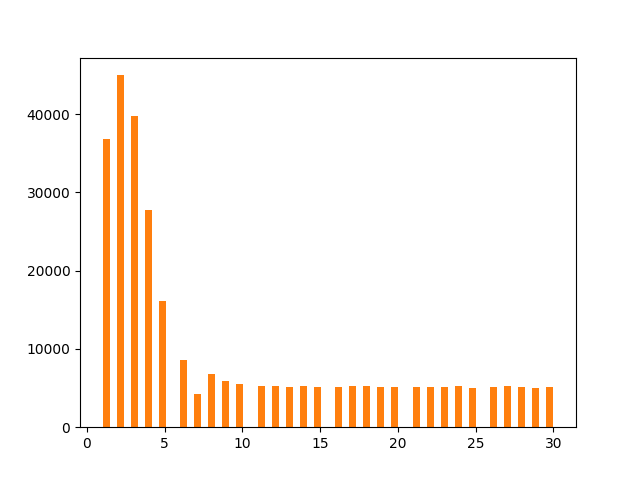

In [38]:
with plt.ioff():
    plt.hist(data['labels'],bins=64)
    plt.show()

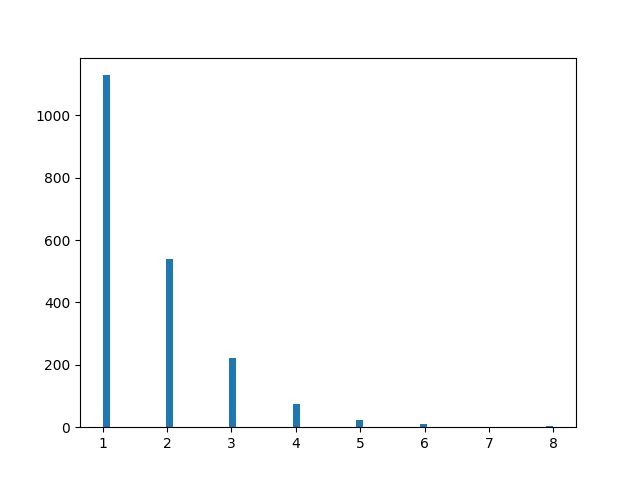

In [50]:
with plt.ioff():
    plt.hist(tune_data['labels'],bins=64)
    plt.show()

# Step 2: Define Transformer Model

In [51]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, device, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, model_dim//2)
        # seq_len is odd
        self.fancy_encoding = torch.repeat_interleave(torch.rand((1, seq_len // 2 + 1, model_dim // 2), device=device), 2, dim=1)
        # cut off last element since the target vertex is not repeated
        self.fancy_encoding = self.fancy_encoding[:, :seq_len, :]
        
        self.model_dim = model_dim
        self.seq_len = seq_len
        self.device = device

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc_out = nn.Linear(model_dim*seq_len, output_dim)

    def forward(self, src, key_padding_mask):
        batch_size, src_len = src.size(0), src.size(1)
        embed = self.embedding(src)
        src = torch.cat((embed * sqrt(self.model_dim), self.fancy_encoding.repeat((batch_size, 1, 1))), dim=2)

        output = self.transformer_encoder(src, src_key_padding_mask=key_padding_mask)
        output[key_padding_mask] = 0 # Hack to stop no_grad problem
        flat_output = torch.flatten(output, start_dim=1, end_dim=2)
        output = self.fc_out(flat_output)
        return output

# Step 3: Load Data

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', "CUDA is not available. Please check your GPU setup."

# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS # one more than the max number of vertices
MODEL_DIM = 256 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 3072
LR = 0.003
WD = 0.002
NHEADS = 4
NLAYERS = 3
PAD_TOKEN = 0
DROPOUT = 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT, device=device).to(device)

with open("data.pkl", "rb") as f:
    pickled_stuff = pickle.load(f)

data = pickled_stuff["data"].to(device)
label = pickled_stuff["labels"].to(device)
padding_mask = (data == PAD_TOKEN).bool().to(device)
dataset = TensorDataset(data, label, padding_mask)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [.8, .2])
train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BSZ, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters in the model: {trainable_params//1000}K")

Trainable parameters in the model: 2390K


In [63]:
baseline_error = criterion(label, torch.tensor(1.5, dtype=torch.float32, device=device))
print(baseline_error)

tensor(141.4637, device='cuda:0')


# Step 4: Train the Model for the first task

In [60]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_src, batch_labels, batch_padding_mask in test_loader:
            output = model(batch_src, batch_padding_mask)
            loss = criterion(output.squeeze(1), batch_labels)
            test_loss += loss.item()/len(test_loader)
    return test_loss

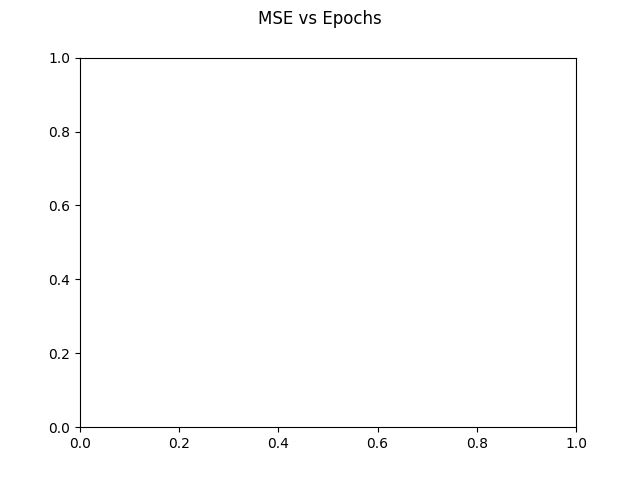

In [74]:
# This has to be in a separate cell for some weird event loop reasons
fig,ax = plt.subplots()
fig.suptitle('MSE vs Epochs')
plt.show()

In [ ]:
train_err = []
test_err = []

for epoch in range(NEPOCHS):
    model.train()
    train_loss = 0
    for batch_src, batch_labels, batch_padding_mask in train_loader:
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item()/len(train_loader)
        loss.backward()
        optimizer.step()

    test_loss = evaluate()
            
    test_err.append(test_loss)
    train_err.append(train_loss)
    ax.plot(train_err, label='Train', color='blue')
    ax.plot(test_err, label='Test', color='red')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    fig.canvas.draw()
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f} \t baseline err: {baseline_error:.4f}")

    if epoch % 100 == 99:
        torch.save(model.state_dict(), f"model_weights_{epoch}.pth")

Epoch 1/1000 	 Train Err: 88.4438 	 Test Err: 72.6466 	 baseline err: 141.4637
Epoch 2/1000 	 Train Err: 72.6060 	 Test Err: 75.4987 	 baseline err: 141.4637
Epoch 3/1000 	 Train Err: 72.6729 	 Test Err: 73.9506 	 baseline err: 141.4637
Epoch 6/1000 	 Train Err: 72.7866 	 Test Err: 72.4612 	 baseline err: 141.4637
Epoch 7/1000 	 Train Err: 73.0815 	 Test Err: 74.9404 	 baseline err: 141.4637
Epoch 8/1000 	 Train Err: 72.8054 	 Test Err: 73.7412 	 baseline err: 141.4637
Epoch 9/1000 	 Train Err: 73.0514 	 Test Err: 82.7393 	 baseline err: 141.4637
Epoch 10/1000 	 Train Err: 73.0291 	 Test Err: 72.2577 	 baseline err: 141.4637
Epoch 11/1000 	 Train Err: 73.0081 	 Test Err: 72.4944 	 baseline err: 141.4637
Epoch 12/1000 	 Train Err: 72.6500 	 Test Err: 75.2036 	 baseline err: 141.4637
Epoch 13/1000 	 Train Err: 72.6255 	 Test Err: 73.4970 	 baseline err: 141.4637
Epoch 14/1000 	 Train Err: 72.6803 	 Test Err: 74.0005 	 baseline err: 141.4637
Epoch 15/1000 	 Train Err: 72.7032 	 Test Err: 

In [80]:
evaluate()

55.06520214080811

In [ ]:
batch_src, batch_labels, batch_padding_mask = next(iter(train_loader))
output = model(batch_src, batch_padding_mask)
batch_src[0], batch_labels[0], output[0]

In [ ]:
plt.hist(output.detach().cpu().numpy().flatten(),bins=32)

In [ ]:
plt.hist(label.detach().cpu().numpy().flatten(),bins=32)

In [ ]:
plt.scatter(batch_labels.detach().cpu().numpy().flatten(),output.detach().cpu().numpy().flatten())

In [ ]:
batch_src2, batch_labels2, batch_padding_mask2 = next(iter(test_loader))
output2 = model(batch_src2, batch_padding_mask2)
loss = criterion(output2.squeeze(1), batch_labels2)
batch_src2[0], batch_labels2[0], output2[0], loss

In [ ]:
plt.scatter(batch_labels2.detach().cpu().numpy().flatten(),output2.detach().cpu().numpy().flatten())

# Step 5: Fine Tune

In [ ]:
N_TUNE_EPOCHS = 100
TUNE_BSZ = 1024
TUNE_LR = 0.003
TUNE_WD = 0.002

with open("tune_data.pkl", "rb") as f:
    pickled_tune_stuff = pickle.load(f)

tune_data = pickled_tune_stuff["data"].to(device)
tune_label = pickled_tune_stuff["labels"].to(device)
tune_padding_mask = (tune_data == PAD_TOKEN).bool().to(device)
tune_dataset = TensorDataset(tune_data, tune_label, tune_padding_mask)
tune_train_dataset, tune_test_dataset = torch.utils.data.random_split(tune_dataset, [.8, .2])
tune_train_loader = DataLoader(tune_train_dataset, batch_size=TUNE_BSZ, shuffle=True)
tune_test_loader = DataLoader(tune_test_dataset, batch_size=TUNE_BSZ, shuffle=True)

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

In [ ]:
# This has to be in a separate cell for some weird event loop reasons
%matplotlib widget
fig,ax = plt.subplots()
fig.suptitle('MSE vs Epochs')
plt.show()

In [ ]:
ax.clear()

tune_train_err = []
tune_test_err = []

for epoch in range(N_TUNE_EPOCHS):
    model.train()
    tune_train_loss = 0
    for batch_src, batch_labels, batch_padding_mask in tune_train_loader:
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        tune_train_loss += loss.item()/len(tune_train_loader)
        loss.backward()
        optimizer.step()

    model.eval()
    tune_test_loss = 0
    with torch.no_grad():
        for batch_src, batch_labels, batch_padding_mask in tune_test_loader:
            output = model(batch_src, batch_padding_mask)
            loss = criterion(output.squeeze(1), batch_labels)
            tune_test_loss += loss.item()/len(tune_test_loader)
            
    tune_test_err.append(tune_test_loss)
    tune_train_err.append(tune_train_loss)
    ax.plot(tune_train_err, label='Train', color='blue')
    ax.plot(tune_test_err, label='Test', color='red')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    fig.canvas.draw()
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f} \t baseline err: {baseline_error:.4f}")

    if epoch % 100 == 9:
        torch.save(model.state_dict(), f"tune_model_weights_{epoch}.pth")

# Step 6: Test generalization